In [33]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix
from scipy.sparse import save_npz

from mimic_helper_fs import get_icd_code_long_title, get_icd_codes_with_prefix
from mimic_helper_fs import get_ids_with_icd_codes, get_ids_with_kws
from mimic_paths import english_names_path, hosp_diagnoses_path, ed_diagnoses_path
from mimic_paths import admissions_path, patients_path


np.random.seed(42)
pd.set_option('max_rows', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 80)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Code to load each table

In [8]:
english_names = pd.read_csv(english_names_path)    # https://mimic.mit.edu/docs/iv/modules/hosp/d_icd_diagnoses/
hosp_diagnoses = pd.read_csv(hosp_diagnoses_path)  # https://mimic.mit.edu/docs/iv/modules/hosp/diagnoses_icd/
ed_diagnoses = pd.read_csv(ed_diagnoses_path)      # https://mimic.mit.edu/docs/iv/modules/ed/diagnosis/
admissions = pd.read_csv(admissions_path)          # https://mimic.mit.edu/docs/iv/modules/core/admissions/
patients = pd.read_csv(patients_path)              # https://mimic.mit.edu/docs/iv/modules/core/patients/

# Considering only diagnoses made in the hospital -- the demographics for patients
# seen in the ED, but not admitted to the hospital, aren't available  yet (but soon will be!)
# the 'triage' table, under the ED module, does contain oxygen readings: 
# https://mimic.mit.edu/docs/iv/modules/ed/triage/
diagnoses = hosp_diagnoses

## Filter for women, >18 years old

In [9]:
sid_gender_map = dict(zip(patients.subject_id, patients.gender))
sid_age_map = dict(zip(patients.subject_id, patients.anchor_age))
sid_ethnicity_map = dict(zip(admissions.subject_id, admissions.ethnicity))
hadm_id_to_subject_id = dict(zip(diagnoses.hadm_id, diagnoses.subject_id))
code_name_map = dict(zip(english_names.icd_code, english_names.long_title))

diagnoses['anchor_age'] = diagnoses['subject_id'].map(sid_age_map)
diagnoses['gender'] = diagnoses['subject_id'].map(sid_gender_map)
diagnoses['ethnicity'] = diagnoses['subject_id'].map(sid_ethnicity_map)

In [16]:
# You may want to filter out rare codes, 
# to reduce the dimensionality of the one-hot encoding:
code_occurrence_thresh = 10
n_codes_present = len(set(diagnoses['icd_code']))
code_counts =  diagnoses.value_counts("icd_code")
code_counts = code_counts.reset_index()
code_list = list(code_counts[code_counts[0] >= code_occurrence_thresh]['icd_code']) 
code_list = sorted(list(set(code_list)))
print("# of ICD codes originally: ", n_codes_present)
print("# of ICD codes that appear > " + str(code_occurrence_thresh) + " times: ", len(code_list))

# of ICD codes originally:  27170
# of ICD codes that appear > 10 times:  11974


In [17]:
diagnoses = diagnoses[diagnoses['anchor_age'] > 17]
diagnoses = diagnoses[diagnoses['gender'] == 'F']
diagnoses = diagnoses[diagnoses['icd_code'].isin(code_list)]

all_hadm_ids = sorted(list(set(diagnoses['hadm_id'])))
all_icd_codes = sorted(list(set(diagnoses['icd_code'])))
all_subject_ids = [hadm_id_to_subject_id[hadm_id] for hadm_id in all_hadm_ids]

code_to_index = {c: i for i,c in enumerate(all_icd_codes)}
hadm_id_to_index = {hadm_id: i for i, hadm_id in enumerate(all_hadm_ids)}

print("# of Patients: ", len(set(diagnoses['subject_id'])))
print("# of Individual Stays: ", len(set(diagnoses['hadm_id'])))
print("# of Unique ICD Codes: ", len(all_icd_codes))

# of Patients:  102813
# of Individual Stays:  239613
# of Unique ICD Codes:  11395


## Most common ICD-9 / ICD-10 codes among women, >18 years old

In [21]:
n_admissions = len(set(diagnoses['hadm_id']))

diagnosis_counts = pd.DataFrame(diagnoses['icd_code'].value_counts().reset_index())
diagnosis_counts = diagnosis_counts.rename(columns={'icd_code': 'counts', 'index': 'icd_code'})
diagnosis_counts['prevalence'] = diagnosis_counts['counts']/n_admissions
diagnosis_counts['long_title'] = diagnosis_counts['icd_code'].map(code_name_map)
diagnosis_counts.head(20)

,icd_code,counts,prevalence,long_title
0,4019,53640,0.223861,Unspecified essential hypertension
1,2724,32165,0.134237,Other and unspecified hyperlipidemia
2,53081,27856,0.116254,Esophageal reflux
3,I10,27294,0.113909,Essential (primary) hypertension
4,E785,23384,0.097591,"Hyperlipidemia, unspecified"
5,311,21922,0.091489,"Depressive disorder, not elsewhere classified"
6,2449,21390,0.089269,Unspecified acquired hypothyroidism
7,25000,21145,0.088246,"Diabetes mellitus without mention of complication, type II or unspecified ty..."
8,K219,19552,0.081598,Gastro-esophageal reflux disease without esophagitis
9,F329,17950,0.074912,"Major depressive disorder, single episode, unspecified"


## One-hot encoding patient visits

In [23]:
one_hot = pd.get_dummies(diagnoses['icd_code'], sparse=True)
hadm_one_hot = pd.concat([diagnoses['hadm_id'], one_hot], axis=1)

diagnoses['icd_code_idx'] = diagnoses['icd_code'].map(code_to_index)
diagnoses['hadm_id_idx'] = diagnoses['hadm_id'].map(hadm_id_to_index)


In [38]:
# Write out one-hot features in coordinate format (helpful since matrix is very sparse)
row_coords = np.array(diagnoses['hadm_id_idx'])
col_coords = np.array(diagnoses['icd_code_idx'])
vals = np.ones(len(col_coords))

n_rows = np.max(row_coords) + 1
n_cols = np.max(col_coords) + 1

# Dummy feature for intercept
intercept_row_coords = np.array(list(range(n_rows)))
intercept_col_coords = [n_cols for i in range(n_rows)]
intercept_vals = np.ones(n_rows)

# Combine features & dummy feature for intercept
row_coords = np.concatenate([row_coords, intercept_row_coords])
col_coords = np.concatenate([col_coords, intercept_col_coords])
vals = np.concatenate([vals, intercept_vals])

# Create sparse matrix
features = coo_matrix((vals, (row_coords, col_coords)))

In [45]:
n_codes_per_patient = np.sum(features, axis=0)


Text(0.5, 1.0, '# of ICD Codes')

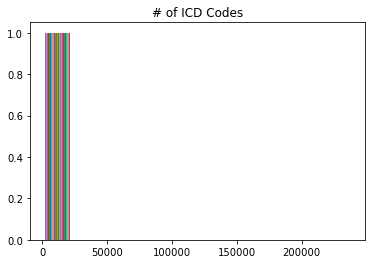

In [47]:
plt.hist(n_codes_per_patient[0])
plt.title("# of ICD Codes per Patient")

##  Get name of a specific  ICD code

In [30]:
# Get first code that starts with a prefix
get_icd_code_long_title(english_names, 'W13')

'Fall from, out of or through building or structure'

In [37]:
# Get all codes that starts with a prefix
all_codes = get_icd_codes_with_prefix(english_names, 'W1')
for code in all_codes:
    print(get_icd_code_long_title(english_names, code))

Fall on and from stairs and steps
Fall (on)(from) escalator
Fall (on)(from) escalator, initial encounter
Fall (on)(from) escalator, subsequent encounter
Fall (on)(from) escalator, sequela
Fall (on)(from) sidewalk curb
Fall (on)(from) sidewalk curb, initial encounter
Fall (on)(from) sidewalk curb, subsequent encounter
Fall (on)(from) sidewalk curb, sequela
Fall (on)(from) incline
Fall (on)(from) incline, initial encounter
Fall (on)(from) incline, subsequent encounter
Fall (on)(from) incline, sequela
Fall (on) (from) other stairs and steps
Fall (on) (from) other stairs and steps, initial encounter
Fall (on) (from) other stairs and steps, subsequent encounter
Fall (on) (from) other stairs and steps, sequela
Fall (on) (from) unspecified stairs and steps
Fall (on) (from) unspecified stairs and steps, initial encounter
Fall (on) (from) unspecified stairs and steps, subsequent encounter
Fall (on) (from) unspecified stairs and steps, sequela
Fall on and from ladder
Fall on and from ladder, ini

Fall in (into) bucket of water causing drowning and submersion, subsequent encounter
Fall in (into) bucket of water causing drowning and submersion, sequela
Fall in (into) bucket of water causing other injury
Fall in (into) bucket of water causing other injury, initial encounter
Fall in (into) bucket of water causing other injury, subsequent encounter
Fall in (into) bucket of water causing other injury, sequela
Fall into other water
Fall into other water striking water surface
Fall into other water striking water surface causing drowning and submersion
Fall into other water striking water surface causing drowning and submersion, initial encounter
Fall into other water striking water surface causing drowning and submersion, subsequent encounter
Fall into other water striking water surface causing drowning and submersion, sequela
Fall into other water striking water surface causing other injury
Fall into other water striking water surface causing other injury, initial encounter
Fall into

Jumping or diving from boat striking bottom causing drowning and submersion, sequela
Jumping or diving from boat striking bottom causing other injury
Jumping or diving from boat striking bottom causing other injury, initial encounter
Jumping or diving from boat striking bottom causing other injury, subsequent encounter
Jumping or diving from boat striking bottom causing other injury, sequela
Jumping or diving into other water
Jumping or diving into other water striking water surface
Jumping or diving into other water striking water surface causing drowning and submersion
Jumping or diving into other water striking water surface causing drowning and submersion, initial encounter
Jumping or diving into other water striking water surface causing drowning and submersion, subsequent encounter
Jumping or diving into other water striking water surface causing drowning and submersion, sequela
Jumping or diving into other water striking water surface causing other injury
Jumping or diving into 

Slipping, tripping and stumbling without falling due to stepping into hole or opening, subsequent encounter
Slipping, tripping and stumbling without falling due to stepping into hole or opening, sequela
Slipping, tripping and stumbling without falling due to stepping from one level to another
Slipping, tripping and stumbling without falling due to stepping from one level to another, initial encounter
Slipping, tripping and stumbling without falling due to stepping from one level to another, subsequent encounter
Slipping, tripping and stumbling without falling due to stepping from one level to another, sequela
Other slipping, tripping and stumbling without falling
Other slipping, tripping and stumbling without falling, initial encounter
Other slipping, tripping and stumbling without falling, subsequent encounter
Other slipping, tripping and stumbling without falling, sequela
Unspecified fall
Unspecified fall, initial encounter
Unspecified fall, subsequent encounter
Unspecified fall, seq